In [1]:
%load_ext autoreload
%autoreload 2

## DCR Slope Precision Metric

<br>**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 08-10-20
<br>**Short description:**
This notebook build upon Peter Yoachim's `DcrPrecisionMetric` demonstrated [here](https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/metrics/dcrMetric.py). 

### 0. Software Setup

In [1]:
your_username = ''

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

# import convenience functions
from opsimUtils import *

In [4]:
# import dask and create client
from dask.distributed import Client
client = Client(n_workers=16)
client

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Client Scheduler: tcp://127.0.0.1:34465,Cluster Workers: 16 Cores: 16 Memory: 257.77 GB


## 1. The Metric

### 1.2 Define the metric

In [5]:
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils.astrometryUtils import m52snr, astrom_precision

class AGN_DCR(BaseMetric):
    """AGN DCR"""
    
    def __init__(self, band, src_mag=22, seeingCol='seeingFwhmGeom', m5Col='fiveSigmaDepth',
                 PACol='paraAngle', filterCol='filter', atm_err=0.01, **kwargs):
        
        self.band = band # required
        self.src_mag = src_mag
        self.m5Col = m5Col
        self.PACol = PACol
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.atm_err = 0.01
        self.metricName = f'DCR_{src_mag}_{self.band}'
        
        cols=['airmass', self.filterCol, self.m5Col, self.PACol, self.seeingCol]
        super(AGN_DCR, self).__init__(col=cols, metricName=self.metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # get the data only corresponding the the desired filter
        data_filt = dataSlice[np.where(dataSlice[self.filterCol] == self.band)]
        
        # Compute the SNR from the observed mag and limiting mag
        # https://sims-maf.lsst.io/_modules/lsst/sims/maf/utils/astrometryUtils.html#m52snr
        snr = m52snr(self.src_mag, data_filt[self.m5Col])

        # The positional error is just the seeing scaled by the SNR with the error floor added in quadrature
        # https://sims-maf.lsst.io/_modules/lsst/sims/maf/utils/astrometryUtils.html#astrom_precisio
        pos_var = np.power(astrom_precision(data_filt[self.seeingCol], snr), 2) \
                  + self.atm_err**2
        pos_err = np.sqrt(pos_var)
        
        # compute tan(Z)
        # note that the PA drops out in the end
        zenith = np.arccos(1/data_filt['airmass'])
        x_coord = np.tan(zenith)*np.sin(np.radians(dataSlice[self.PACol]))
        x_coord2 = np.tan(zenith)*np.cos(np.radians(dataSlice[self.PACol]))
        

        # function is of form, y=ax. a=y/x. da = dy/x.
        # Only strictly true if we know the unshifted position. But this should be a reasonable approx.
        slope_uncerts = pos_err/x_coord
        slope_uncerts2 = pos_err/x_coord2

        total_slope_uncert = 1./np.sqrt(np.sum(1./slope_uncerts**2)+np.sum(1./slope_uncerts2**2))

        # Assuming we know the unshfted position of the object (or there's little covariance if we are fitting for both)
        result = total_slope_uncert

#       ## version from Bevington page 109 from least-square
#       Delta = np.sum(1/pos_var)*np.sum(x_coord**2/pos_var) - np.power(np.sum(x_coord/pos_var), 2)
#       result = np.sqrt(np.sum(x_coord**2/pos_var)/Delta)
        
        return result

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/0807/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/0807/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))
    
if not os.path.exists(os.path.abspath(metricDataPath)):
    os.makedirs(os.path.abspath(metricDataPath))

In [7]:
dbRuns = show_opsims(dbDir)
dbRuns[0:5] # only show first 5 opsims

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs']

### 1.3 Select one OpSim from each family

Where family is indicated by the first part (before the 1st underscore) of the DB file name

In [8]:
dbFamil = [run.split('_')[0] for run in dbRuns]
dfRuns = pd.DataFrame({'run':dbRuns, \
                       'runFamil':dbFamil}).sort_values(by='runFamil').reset_index(drop=True)
dfRuns.head()

,run,runFamil
0,agnddf_v1.5_10yrs,agnddf
1,alt_dust_v1.5_10yrs,alt
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs,alt
3,baseline_2snaps_v1.5_10yrs,baseline
4,baseline_v1.5_10yrs,baseline


In [9]:
# pick on run from each family
dfRunPick = dfRuns.drop_duplicates(subset=['runFamil']).reset_index(drop=True)
dfRunPick

,run,runFamil
0,agnddf_v1.5_10yrs,agnddf
1,alt_dust_v1.5_10yrs,alt
2,baseline_2snaps_v1.5_10yrs,baseline
3,bulges_cadence_bs_v1.5_10yrs,bulges
4,daily_ddf_v1.5_10yrs,daily
5,dcr_nham1_ugri_v1.5_10yrs,dcr
6,descddf_v1.5_10yrs,descddf
7,filterdist_indx8_v1.5_10yrs,filterdist
8,footprint_gp_smoothv1.5_10yrs,footprint
9,goodseeing_gri_v1.5_10yrs,goodseeing


If you want to run all the runs, use "dfRuns".  If you are happy just looking at an example from each family, then use "dfRunPick" below.

In [10]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=dfRunPick.run.values)

### 2. Declare metrics to for gmag = [19, 21, 23, 25]

This range of g magnitude used for testing spans objects bright enough that DCR is dominated by the floor on the astrometric error and extends to objects so faint that DCR simply cannot be measured.  

Almost all of this notebook is generic and not related to AGNs at all.  The exception is the explicit connection between the u and g magnitudes in this cell (setting the mean u-g to 0.15).  This makes the AGN analysis from NOTEBOOK easier, but could/should be changed by users interested in other SEDs.

In [11]:
bundleDict = {}
for gmag in [19, 21, 23, 25]:
    
    # declare metric, slicer and sql contraint
    DCR_metricG = AGN_DCR('g', src_mag=gmag)
    slicer = slicers.HealpixSlicer(nside=64)
    constraintG = 'filter = "g"'
    constraintG += ' and note not like "DD%"'
    constraintG += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbG = metricBundles.MetricBundle(DCR_metricG, slicer, constraintG)
    summaryMetrics = [metrics.MedianMetric(), metrics.MeanMetric(), metrics.RmsMetric()]
    DCR_mbG.setSummaryMetrics(summaryMetrics)
    
    # declare u band metric
    DCR_metricU = AGN_DCR('u', src_mag=gmag+0.15)
    constraintU = 'filter = "u"'
    constraintU += ' and note not like "DD%"'
    constraintU += ' and proposalId = 1'
    
    # make a bundle
    DCR_mbU = metricBundles.MetricBundle(DCR_metricU, slicer, constraintU)
    DCR_mbU.setSummaryMetrics(summaryMetrics)

    # put into dict
    bundleDict[DCR_metricG.metricName] = DCR_mbG
    bundleDict[DCR_metricU.metricName] = DCR_mbU

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### 3. Loop over all OpSims in dbDir and run MAF
While constructing a metricBundleGroup from a dictionary (the cell below), you will need to provide the path to a directory (`metricDataPath` in the cell below) where you would like to store the metric data (this is **DIFFERENT** than path to the metric data, `outDir`). To construct metricbundles for plotting and further analysis, this path will be needed.

__Note:__ The code the cell below is deprecated since the dask version is much faster, but it is left here for reference. 

In [13]:
# # below I am only going to run metrics on the first five opsims
# for run in dbRuns[0:3]:
#     # must set run name for each opSim to store metric data into
#     # separate files
#     print(f'Running metrics on: {run}')
#     print('*************************************')
#     for key in bundleDict:
#         bundleDict[key].setRunName(run)
        
#     metricGroup = metricBundles.MetricBundleGroup(bundleDict,\
#                     opSimDbs[run], metricDataPath, resultDbs[run], verbose=False)
#     metricGroup.runAll()

#### 3.1 Run them in parallel with Dask (installing Dask.distributed is required)

Install with: 
```
conda install dask distributed -c conda-forge
```

or:

```
python -m pip install dask distributed --upgrade
```

In [14]:
# define function to run MAF on one opsim which is easily parallelziable. 
def run_mg(run, bundleDict, dbDir, outDir, metricDataPath):
    """
    Function to run pre-defined MAF metrics on one OpSim. 
    
    Args:
        run (str): The OpSim cadence run name.
        bundleDict (dict): A dictionary of MAF metrics.
        dbDir (str): The path to the OpSim databases.
        outDir (str): The path to the resultdb databases.
        metricDataPath (str): The path to the actual metric data (.npz files). 
    """
    for key in bundleDict:
        bundleDict[key].setRunName(run)
    
    # init connection given run name
    opSimDb, resultDb = connect_dbs(dbDir, outDir, dbRuns=[run])
    # make a group
    metricGroup = metricBundles.MetricBundleGroup(bundleDict, opSimDb[run], metricDataPath, \
                                                  resultDb[run], verbose=False)
    metricGroup.runAll()


# %%time
rt = []

# loop over all opsims to evaluate and submite task to dask scheduler
for run in dfRunPick.run.values:
    r = client.submit(run_mg, run, bundleDict, dbDir, outDir, metricDataPath)
    rt.append(r)
    
# collect result
result = client.gather(rt)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/distributed/worker.py:3101: UserWarning: Large object of size 4.74 MB detected in task graph: 
  ('agnddf_v1.5_10yrs', {'DCR_19_g': <lsst.sims.maf. ... 7/MetricData/')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


### 4. Take a peek at the distribution of the metrics
#### 4.1 Import metric data & Check metricBundle keys

In [12]:
# import metric evaluations
bundleDicts = {}
resultDbPath = outDir

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [13]:
# Check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[1]].keys())
print(bd_keys)

[(1, 'DCR_19_g'), (2, 'DCR_21_g'), (3, 'DCR_23_g'), (4, 'DCR_25_g'), (5, 'DCR_19.15_u'), (6, 'DCR_21.15_u'), (7, 'DCR_23.15_u'), (8, 'DCR_25.15_u')]


#### 4.2 Histograms
Histogram of DCR slope precision for gmag in [19, 21, 23, 25]

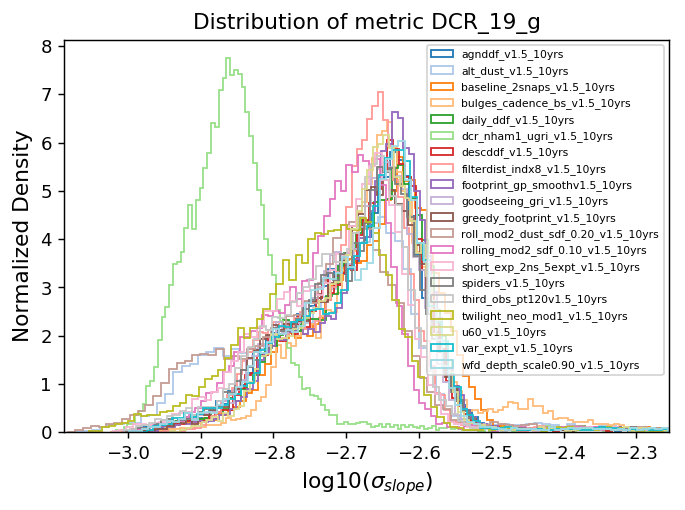

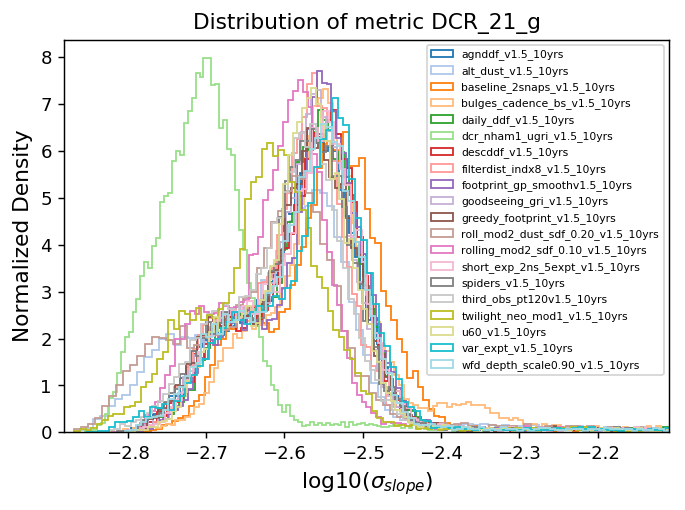

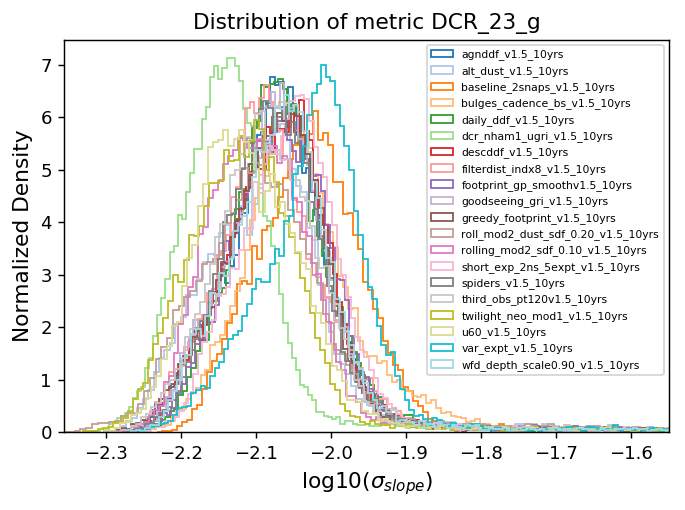

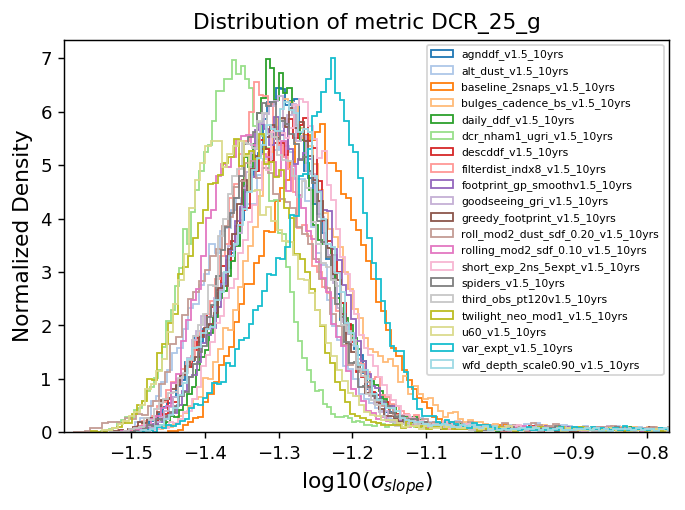

In [14]:
# loop though each metric to make plots, since some values are fairly large 
# and built in functions doesn't allow log scale

# options to provide same xlim for all metric plots
# provide a number if you want uniform xlim for all plots
xMax = None
xMin = None

# whether to save as PNGs
savefig = False

for key in bd_keys:
    if key[1].split('_')[-1] == 'g':
        
        fig = plt.figure(dpi=130)
        for i, run in enumerate(resultDbsView):

            # look for the correct combination of metricID and metricName 
            keys = [*bundleDicts[run].keys()]
            metricKey = [elem for elem in keys if elem[1] == key[1]][0]

            # need to mask the pixels that have no available data
            mask = bundleDicts[run][metricKey].metricValues.mask
            data = bundleDicts[run][metricKey].metricValues.data[~mask]

            # plot
            _ = plt.hist(np.log10(data), bins='fd', histtype='step', color=mpl.cm.tab20.colors[i], \
                         density=True, label=f'{run}')
            plt.xlabel('log10($\\sigma_{slope}$)', fontsize=12)
            plt.ylabel('Normalized Density', fontsize=12)
            plt.legend(fontsize=6)
            plt.xlim(right = np.log10(np.percentile(data, 99)))

        # check if uniform xlim provided
        if xMax is not None:
            plt.xlim(right=xMax)
        if xMin is not None:
            plt.xlim(left=xMin)

        plt.title(f'Distribution of metric {key[1]}', fontsize=12)
        # options to save
        if savefig:
            plt.savefig(f'Distribution of metric {key[1]}.png', dpi=200)

### 4.3 SkyPlots
Show the slope uncertainty over the sky

<!-- __WY:__ Didn't find a easy way to plot healpy plot side by side, healpy takes figure as input, not axes. 
Might find better ways in the future -->

In [16]:
# function to make sky plot
import healpy as hp
def plotSky_scale(mb, scale_func=np.log10, minVal=None, maxVal=None, **kwargs):
    '''
    Plot High-Res DDF skymap. 
    Args:
        mb: MetricBundle object.
        scale_func (func): A scaling function for the metric data, e.g., np.log10
        minVal (float): Mininum value to plot
        maxVal (float): Maximum value to plot
    '''
    

    try:
        mbValues = mb.metricValues.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        nData = scale_func(data)
    except Exception as e:
        print(e)
        return None
    else:
        mbValues.data[~mask] = nData
    
    if maxVal is None:
        maxVal = np.percentile(nData, 99)
    if minVal is None: 
        minVal = np.percentile(nData, 1)
        
    _ = hp.mollview(mbValues, flip='astro', max=maxVal, min=minVal, **kwargs)

    _ = hp.graticule(dpar=30, dmer=30, verbose=False)
    plt.title(f'Metric:{mb.metric.name}, RunName:{mb.runName}', fontsize=15)

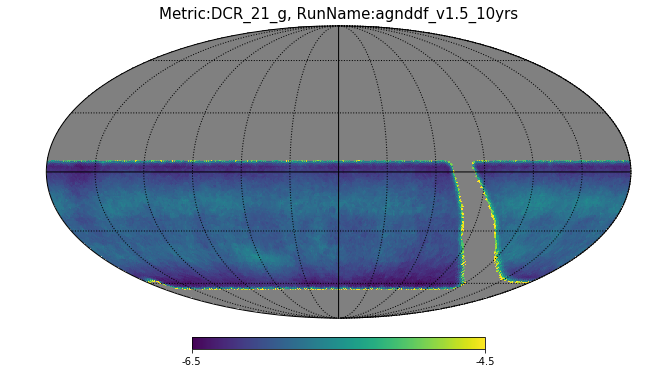

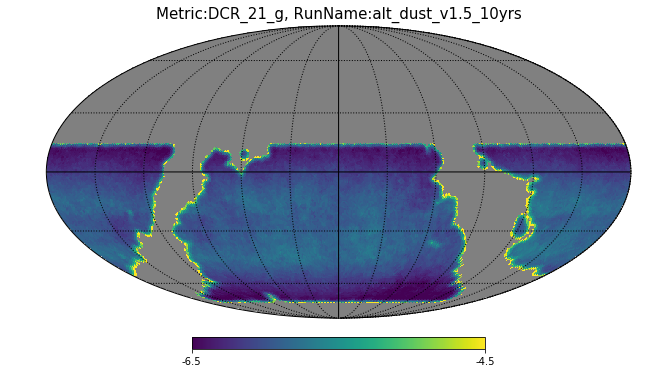

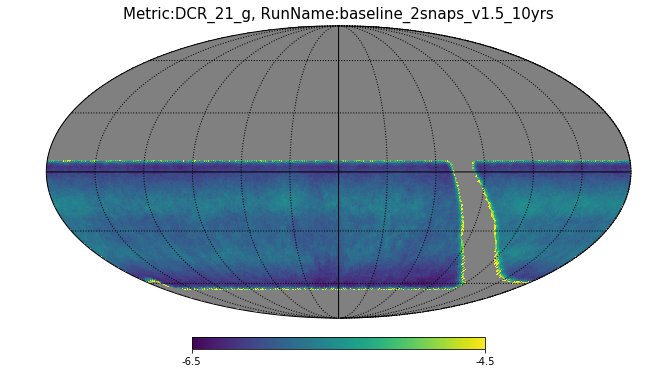

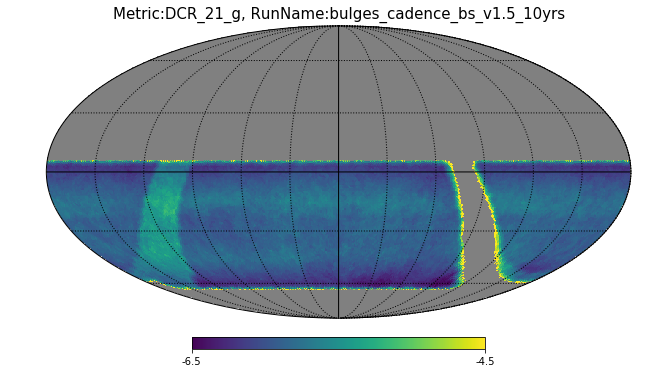

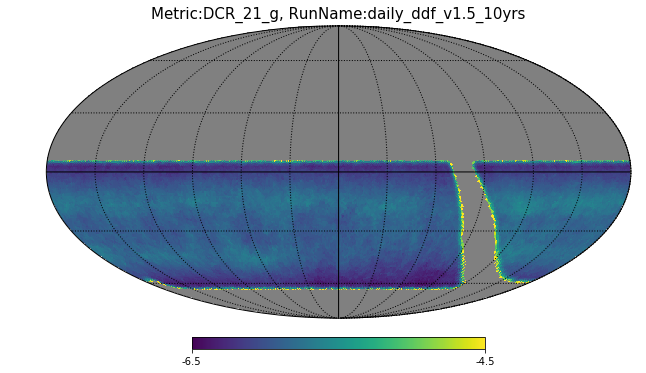

In [17]:
# only plotting first few opsims to save space
for k, run in enumerate(resultDbsView):
    if k < 5:
        
        # loop over the (magnitude dependent) metrics, here only DCR_21_g
        for i, gmag in enumerate([21]):
            
            if i < 4:
                key = (i, f'DCR_{gmag}_g')

                # look for the correct combination of metricID and metricName 
                keys = [*bundleDicts[run].keys()]
                metricKeyG = [elem for elem in keys if elem[1] == key[1]][0]
                plotSky_scale(bundleDicts[run][metricKeyG], np.log, maxVal=-4.5, minVal=-6.5) # uniform lim